### Assessment of different steady-state solver methods
Nathaniel Linden; Feb 2024

To find a system's steady-state, ${\rm d}\mathbf{x}/{\rm d}t$, we currently run the ODE until the following condition is met:
$$
    \frac{{\rm d}\mathbf{x}}{{\rm d}t} < {\rm atol} + {\rm rtol} \times \mathbf{x}
$$
Where the steady-state solution is quite sensitive to the choice of the tolerances. (See results in ../test_models_sandbox.ipynb).
Additionally, we impose a maximum time, $t_{\rm max}$ that an ODE is solved to. This is to prevent computation from running too long if the steady-state condition is not reached.

We can alternatively use a Newton solver to find the steady-state solution by solving the the root finding problem
$$
   \frac{{\rm d}\mathbf{x}}{{\rm d}t} = 0.
$$

This notebook compares the two methods for several models that normally take a long time to reach steady-state with the ODE solver method.
We compare three approaches:
1. ODE solver method as-is
2. Netwon solver method with ODE IC as the initial guess
3. Netwon solver method with a shortish ODE run as the initial guess

In [119]:
import numpy as np
import jax.numpy as jnp
import diffrax
import optimistix as optx
import optax
import lineax as lx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import equinox as eqx
import sys
import time
import timeit
from functools import partial
from scipy.stats import mode

sys.path.append("../models/")
sys.path.append("../")
from shin_2014 import *
from hornberg_2005 import *
from vonKriegsheim_2009 import *


from utils import *

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
from plotting_helper_funcs import *


#### Set up ODE solver and Jax RHS function

In [120]:
# first write few helper function 
@jax.jit
def solve_to_SS(model_dfrx_ode, y0, params, t1, event_rtol=1e-6, event_atol=1e-5):
    """ simulates a model over the specified time interval and returns the 
    calculated values.
    Returns an array of shape (n_species, 1) """
    dt0=1e-3
    solver = diffrax.Kvaerno5()
    event=diffrax.SteadyStateEvent(event_rtol, event_atol)
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0

    sol = diffrax.diffeqsolve(
        model_dfrx_ode, 
        solver, 
        t0, 
        t1, 
        dt0, 
        y0, 
        stepsize_controller=stepsize_controller,
        discrete_terminating_event=event,
        # saveat=saveat,
        args=params,
        max_steps=6000000,
        throw=False,)
    
    return sol.ys, sol.ts

def solve_traj(model_dfrx_ode, y0, params, t1, times):
    """ simulates a model over the specified time interval and returns the 
    calculated values.
    Returns an array of shape (n_species, 1) """
    dt0=1e-3
    saveat=diffrax.SaveAt(ts=times)
    solver = diffrax.Kvaerno3()
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0

    sol = diffrax.diffeqsolve(
        model_dfrx_ode, 
        solver, 
        t0, 
        t1, 
        dt0, 
        y0, 
        stepsize_controller=stepsize_controller,
        saveat=saveat,
        args=params,
        max_steps=6000000,
        throw=False,)
    
    print(sol.result)
    
    return sol.ys, sol.ts

# load model info and parameter samples
# Note this uses the param samples from HF96_synthetic_data experiments
def load_system_info_param_samples(model_name, nsamples=40):

    model_info = json.load(open('./model_info.json', 'r'))

    print('loading ' +model_name)
    info = model_info[model_name]

    inputs, _ = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')
    idata,_ = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/' + model_name + '/' + model_name + '_smc_samples.json')

    model = eval(model_name + '(transient=False)')
    p_dict, _ = model.get_nominal_params()
    y0_dict, y0 = model.get_initial_conditions()

    inputs_native_units = inputs * float(info['EGF_conversion_factor'])
    # get the EGF index and ERK indices
    state_names = list(y0_dict.keys())
    EGF_idx = state_names.index(info['input_state'])
    ERK_indices = [state_names.index(s) for s in info['ERK_states'].split(',')]

    # make initial conditions that reflect the inputs
    y0_EGF_ins = construct_y0_EGF_inputs(inputs_native_units, np.array([y0]), EGF_idx)

    param_samples = get_param_subsample(idata, nsamples, p_dict)

    if info['max_time'] == 'inf':
        t1 = jnp.inf
    else:
        t1 = float(info['max_time'])
        # t1 = jnp.inf

    return model, y0_EGF_ins, param_samples, t1, ERK_indices, EGF_idx

def find_ss_ODE_solver(model, y0, param, t1, event_rtol=1e-6, event_atol=1e-5):
    sol, ts = solve_to_SS(diffrax.ODETerm(model), y0, param, t1, event_rtol=event_rtol, event_atol=event_atol)

    return sol, ts

Now load the info for S' 2014, vK' 2009, and H' 2005 models

In [121]:
nparams = 100
S_2014, S_2014_y0_EGF_ins, S_2014_param_samples, S_2014_t1, S_2014_ERK_indices, S_2014_EGF_idx = load_system_info_param_samples('shin_2014', nsamples=nparams)
vK_2009, vK_2009_y0_EGF_ins, vK_2009_param_samples, vK_2009_t1, vK_2009_ERK_indices, vK_2009_EGF_idx = load_system_info_param_samples('vonKriegsheim_2009', nsamples=nparams)
H_2005, H_2005_y0_EGF_ins, H_2005_param_samples, H_2005_t1, H_2005_ERK_indices, H_2005_EGF_idx = load_system_info_param_samples('hornberg_2005', nsamples=nparams)

@jax.jit
def S_2014_RHS(y, p):
    EGF, params = p
    y = jnp.hstack((EGF, y))
    return diffrax.ODETerm(S_2014).vf(None, y, params)

@jax.jit
def H_2005_RHS(y, p):
    EGF, params = p
    y = jnp.hstack((EGF, y))
    return diffrax.ODETerm(H_2005).vf(None, y, params)

@jax.jit
def vK_2009_RHS(y, p):
    EGF, params = p
    y = jnp.hstack((0.0, EGF, y))
    return diffrax.ODETerm(vK_2009).vf(None, y, params)

loading shin_2014
loading vonKriegsheim_2009
loading hornberg_2005


### Test Newtons Method against ODE solver for Shin 2014


#### First we try with the ODE solution as the initial guess. Then we try with a shortish ODE run as the initial guess.

In [6]:
# test root finder with Newton's method for the Shin model from the ODE ic...
nEGFS = 10
EGF_idx = 2
EGF = S_2014_y0_EGF_ins[EGF_idx][0]
y0 = S_2014_y0_EGF_ins[EGF_idx][1:]
param = S_2014_param_samples[56]

# This does not perform very well...
solver = optx.Newton(atol=1e-10, rtol=1e-10, linear_solver=lx.AutoLinearSolver(well_posed=False), norm=optx.two_norm)
# solver = optx.BFGS(atol=1e-8, rtol=1e-8)
# solver = optx.LevenbergMarquardt(atol=1e-8, rtol=1e-8)
# solver = optx.Dogleg(atol=1e-10, rtol=1e-10, linear_solver=lx.AutoLinearSolver(well_posed=False))
try:
    print('Trying with ODE ic as Newton initial guess...\n')
    sol_ODEic = optx.root_find(S_2014_RHS, solver, y0, args=(EGF,param), max_steps=10, options={'lower':jnp.zeros_like(y0)})

    print('The solver converged to the following solution:')
    print(sol_ODEic.value)
except Exception as e:
    print('THE SOLVER RETURNED THE FOLLOWING ERROR:')
    sol_ODEic = optx.root_find(S_2014_RHS, solver, y0, args=(EGF,param), max_steps=10, throw=False, options={'lower':jnp.zeros_like(y0)})
    print(e)

Trying with ODE ic as Newton initial guess...

THE SOLVER RETURNED THE FOLLOWING ERROR:
The maximum number of steps was reached in the nonlinear solver. The problem may not be solveable (e.g., a root-find on a function that has no roots), or you may need to increase `max_steps`.
-------
This error occurred during the runtime of your JAX program. Setting the environment
variable `EQX_ON_ERROR=breakpoint` is usually the most useful way to debug such errors.
(This can be navigated using most of the usual commands for the Python debugger:
`u` and `d` to move through stack frames, the name of a variable to print its value,
etc.) See also `https://docs.kidger.site/equinox/api/errors/#equinox.error_if` for more
information.



In [259]:
# get y0 as shortish run of ODE
sol, ts = find_ss_ODE_solver(S_2014, S_2014_y0_EGF_ins[EGF_idx], param, jnp.inf, event_rtol=1e-5, event_atol=1e-4)
y0 = jnp.squeeze(sol)[S_2014_EGF_idx+1:]
try:
    print('Trying with ODE ic as Newton initial guess...\n')
    sol_betterGuess = optx.root_find(S_2014_RHS, solver, y0, args=(EGF,param), max_steps=1000, options={'lower':jnp.zeros_like(y0)})
    print('The solver converged to the following solution:')
    print(sol_betterGuess.value)
except Exception as e:
    print('THE SOLVER RETURNED THE FOLLOWING ERROR:')
    sol_betterGuess = optx.root_find(S_2014_RHS, solver, y0, args=(EGF,param), max_steps=1000, throw=False, options={'lower':jnp.zeros_like(y0)})
    print(e)

Trying with ODE ic as Newton initial guess...

The solver converged to the following solution:
[1.02275675e-09 5.00160000e-09 3.02178354e-06 8.77163688e-04
 5.01010955e-02 2.17575954e-01]


In [260]:
# get SS with differnt ode solve event tolerances
sol_default, ts_default = find_ss_ODE_solver(S_2014, S_2014_y0_EGF_ins[EGF_idx], param, S_2014_t1, event_rtol=1e-6, event_atol=1e-5)

sol_small, ts_small = find_ss_ODE_solver(S_2014, S_2014_y0_EGF_ins[EGF_idx], param, S_2014_t1, event_rtol=1e-10, event_atol=1e-10)

In [261]:
traj, times = solve_traj(diffrax.ODETerm(S_2014), S_2014_y0_EGF_ins[EGF_idx], param, 40000, np.linspace(0, 400, 1000))

0


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_72714/389643129.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  ax.plot([0,float(ts_default[0])], [float(sol_default[:,idx+1]), float(sol_default[:,idx+1])], '--', label=r'ODE method $rtol=1e-6, atol=1e-5$', color='g')
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_72714/389643129.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  ax.plot([0,float(ts_small[0])], [float(sol_small[:,idx+1]), float(sol_small[:,idx+1])], '--', label=r'ODE method $rtol=1e-10, atol=1e-10$', color='b')


(0.0, 883.0761559171655)

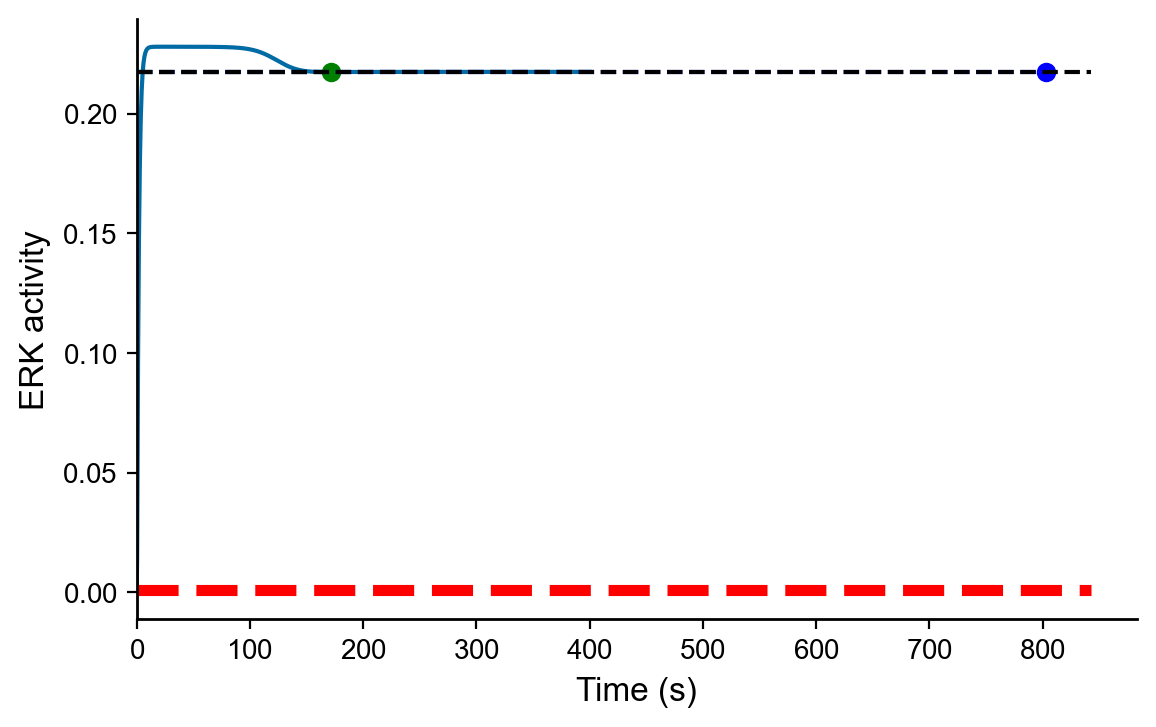

In [262]:
idx = 5
fig, ax = get_sized_fig_ax(5,3)
ax.plot(times, traj[:,idx+1], label='ODE solution')

# plot different steady-state solutions
ax.plot(ts_default, sol_default[:,idx+1], 'o', label=r'ODE method $rtol=1e-6, atol=1e-5$', color='g')
ax.plot([0,float(ts_default[0])], [float(sol_default[:,idx+1]), float(sol_default[:,idx+1])], '--', label=r'ODE method $rtol=1e-6, atol=1e-5$', color='g')

ax.plot(ts_small, sol_small[:,idx+1], 'o', label=r'ODE method $rtol=1e-10, atol=1e-10$', color='b')
ax.plot([0,float(ts_small[0])], [float(sol_small[:,idx+1]), float(sol_small[:,idx+1])], '--', label=r'ODE method $rtol=1e-10, atol=1e-10$', color='b')

xlim = ax.get_xlim()
ax.set_xlim([-5, xlim[1]])
xlim = ax.get_xlim()

ax.plot([0,xlim[1]], [float(sol_ODEic.value[idx]), float(sol_ODEic.value[idx])], '--', label=r'Netwon Method (ODE IC as guess)', color='r', linewidth=4)

ax.plot([0,xlim[1]], [float(sol_betterGuess.value[idx]), float(sol_betterGuess.value[idx])], '--', label='Netwon Method (Crude ODE sim as guess)', color='black')

ax.set_xlabel('Time (s)')
ax.set_ylabel('ERK activity')

ax.set_xlim([0, ts_small[-1]*1.1])



#### Timing test

In [4]:
def find_SS_ODE_init_NEWTON(EGF, param, y0, ODE,ODE_RHS, solver, EGF_idx, warn=True, max_steps=256, max_init_sim_time=jnp.inf):
    sol, _ = find_ss_ODE_solver(ODE, y0, param, max_init_sim_time, event_rtol=1e-5, event_atol=1e-4)
    _y0 = jnp.squeeze(sol)[(EGF_idx+1):]
    
    sol_RF = optx.root_find(ODE_RHS, solver, _y0, args=(EGF,param), max_steps=max_steps, options={'lower':jnp.zeros_like(_y0)},throw=False)

    if warn and (optx.RESULTS[sol_RF.result] != ''):
        print('WARNING: The solver returned the following error:')
        print(optx.RESULTS[sol_RF.result])

    return sol_RF.value

In [31]:
# start = time.time()
iters = 1
times_NEWTON_SHIN = []
times_ODE_SHIN = []
RHS_norms_ODE = []
RHS_norms_Netwon = []

solver = optx.Newton(atol=1e-10, rtol=1e-10, linear_solver=lx.AutoLinearSolver(well_posed=False), norm=optx.max_norm)
# solver = optx.BFGS(atol=1e-8, rtol=1e-8)
for EGF_idx in range(nEGFS):
    for i in range(100):
        EGF = S_2014_y0_EGF_ins[EGF_idx][S_2014_EGF_idx]
        y0 = S_2014_y0_EGF_ins[EGF_idx]
        param = S_2014_param_samples[i]

        # time Netwon approach
        start = timeit.default_timer()
        sol = find_SS_ODE_init_NEWTON(EGF, param, y0, S_2014,S_2014_RHS, solver, S_2014_EGF_idx, warn=False, max_steps=100)
        stop = timeit.default_timer()

        times_NEWTON_SHIN.append(stop-start)
        RHS_norms_Netwon.append(optx.two_norm(S_2014_RHS(sol, (EGF, param))))
        
        # time ODE approach with very low tolerances
        start = timeit.default_timer()
        sol_ode, _ = find_ss_ODE_solver(S_2014, y0, param, S_2014_t1, event_rtol=1e-10, event_atol=1e-10)
        stop = timeit.default_timer()
        times_ODE_SHIN.append(stop-start)
        RHS_norms_ODE.append(optx.two_norm(S_2014_RHS(np.squeeze(sol_ode)[S_2014_EGF_idx+1:], (EGF, param))))

In [24]:
print('Stats for Shin 2014 model: \n')

print(f'Average runtime for Newton method with ODE init: {1000*np.mean(times_NEWTON_SHIN)} plus/minus {1000*np.std(times_NEWTON_SHIN)} ms')
print(f'Average runtime for ODE method: {1000*np.mean(times_ODE_SHIN)} plus/minus {1000*np.std(times_NEWTON_SHIN)} ms')
print(f'Average RHS norm for Newton method with ODE init: {np.nanmean(RHS_norms_Netwon)} plus/minus {np.nanstd(RHS_norms_Netwon)}')
print(f'Average RHS norm for ODE method: {np.nanmean(RHS_norms_ODE)} plus/minus {np.nanstd(RHS_norms_ODE)}')

Stats for Shin 2014 model: 

Average runtime for Newton method with ODE init: 0.634423421084648 plus/minus 0.19316860442092762 ms
Average runtime for ODE method: 0.36325523670529947 plus/minus 0.19316860442092762 ms
Average RHS norm for Newton method with ODE init: 0.0646875137272538 plus/minus 0.6540691898027535
Average RHS norm for ODE method: 1.0449641792952689e-10 plus/minus 7.159759446898424e-11


### Test Newtons Method against ODE solver for Hornberg 2005

#### First just compare approaches

In [298]:
# test root finder with Newton's method for the Shin model from the ODE ic...
nEGFS = 10
EGF_idx = 9
EGF = H_2005_y0_EGF_ins[EGF_idx][0]
y0 = H_2005_y0_EGF_ins[EGF_idx][1:]
param = H_2005_param_samples[0]

# This does not perform very well...
solver = optx.Newton(atol=1e-10, rtol=1e-10, linear_solver=lx.AutoLinearSolver(well_posed=False), norm=optx.max_norm)
# solver = optx.OptaxMinimiser(optax.adabelief(learning_rate=1e-3), rtol=1e-8, atol=1e-8)
# solver = optx.BFGS(atol=1e-8, rtol=1e-8)
# solver = optx.LevenbergMarquardt(atol=1e-8, rtol=1e-8)
# solver = optx.Dogleg(atol=1e-10, rtol=1e-10, linear_solver=lx.AutoLinearSolver(well_posed=False))
# solver = optx.OptaxMinimiser(optax.adam(learning_rate=0.03), rtol=1e-8, atol=1e-8)
try:
    print('Trying with ODE ic as Newton initial guess...\n')
    sol_ODEic = optx.root_find(H_2005_RHS, solver, y0, args=(EGF,param), max_steps=300, options={'lower':jnp.zeros_like(y0)})

    print('The solver converged to the following solution:')
    print(sol_ODEic.value)
except Exception as e:
    print('THE SOLVER RETURNED THE FOLLOWING ERROR:')
    sol_ODEic = optx.root_find(H_2005_RHS, solver, y0, args=(EGF,param), max_steps=300, throw=False, options={'lower':jnp.zeros_like(y0)})
    print(e)

Trying with ODE ic as Newton initial guess...

THE SOLVER RETURNED THE FOLLOWING ERROR:
The maximum number of steps was reached in the nonlinear solver. The problem may not be solveable (e.g., a root-find on a function that has no roots), or you may need to increase `max_steps`.
-------
This error occurred during the runtime of your JAX program. Setting the environment
variable `EQX_ON_ERROR=breakpoint` is usually the most useful way to debug such errors.
(This can be navigated using most of the usual commands for the Python debugger:
`u` and `d` to move through stack frames, the name of a variable to print its value,
etc.) See also `https://docs.kidger.site/equinox/api/errors/#equinox.error_if` for more
information.



In [300]:
# get y0 as shortish run of ODE
sol, ts = find_ss_ODE_solver(H_2005, H_2005_y0_EGF_ins[EGF_idx], param, jnp.inf, event_rtol=1e-5, event_atol=1e-4)
y0 = jnp.squeeze(sol)[1:]

try:
    print('Trying with ODE sol as Newton initial guess...\n')
    sol_betterGuess = optx.root_find(H_2005_RHS, solver, y0, args=(EGF,param), max_steps=10, options={'lower':jnp.zeros_like(y0)})
    print('The solver converged to the following solution:')
    print(sol_betterGuess.value)
    # print(sol_betterGuess.)
except Exception as e:
    print('THE SOLVER RETURNED THE FOLLOWING ERROR:')
    sol_betterGuess = optx.root_find(H_2005_RHS, solver, y0, args=(EGF,param), max_steps=10, throw=False, options={'lower':jnp.zeros_like(y0)})
    print(e)

Trying with ODE sol as Newton initial guess...

THE SOLVER RETURNED THE FOLLOWING ERROR:
The maximum number of steps was reached in the nonlinear solver. The problem may not be solveable (e.g., a root-find on a function that has no roots), or you may need to increase `max_steps`.
-------
This error occurred during the runtime of your JAX program. Setting the environment
variable `EQX_ON_ERROR=breakpoint` is usually the most useful way to debug such errors.
(This can be navigated using most of the usual commands for the Python debugger:
`u` and `d` to move through stack frames, the name of a variable to print its value,
etc.) See also `https://docs.kidger.site/equinox/api/errors/#equinox.error_if` for more
information.



In [301]:
# get SS with differnt ode solve event tolerances
sol_crude, ts_crude = find_ss_ODE_solver(H_2005, H_2005_y0_EGF_ins[EGF_idx], param, S_2014_t1, event_rtol=1e-5, event_atol=1e-3)
sol_default, ts_default = find_ss_ODE_solver(H_2005, H_2005_y0_EGF_ins[EGF_idx], param, S_2014_t1, event_rtol=1e-6, event_atol=1e-5)

# # traj, times = solve_traj(diffrax.ODETerm(H_2005), H_2005_y0_EGF_ins[EGF_idx], param, 1e10, np.linspace(0, 1e10, 60000))
traj, times = solve_traj(diffrax.ODETerm(H_2005), H_2005_y0_EGF_ins[EGF_idx], param, 1e10, np.linspace(0, 3e4, 90000))

0


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_72714/169898580.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  ax.plot([0,float(ts_default[0])], [float(sol_default[:,idx+1]), float(sol_default[:,idx+1])], '--', label='', color='g')
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_72714/169898580.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  ax.plot([0,float(ts_crude[0])], [float(sol_crude[:,idx+1]), float(sol_crude[:,idx+1])], '--', label='', color='g')


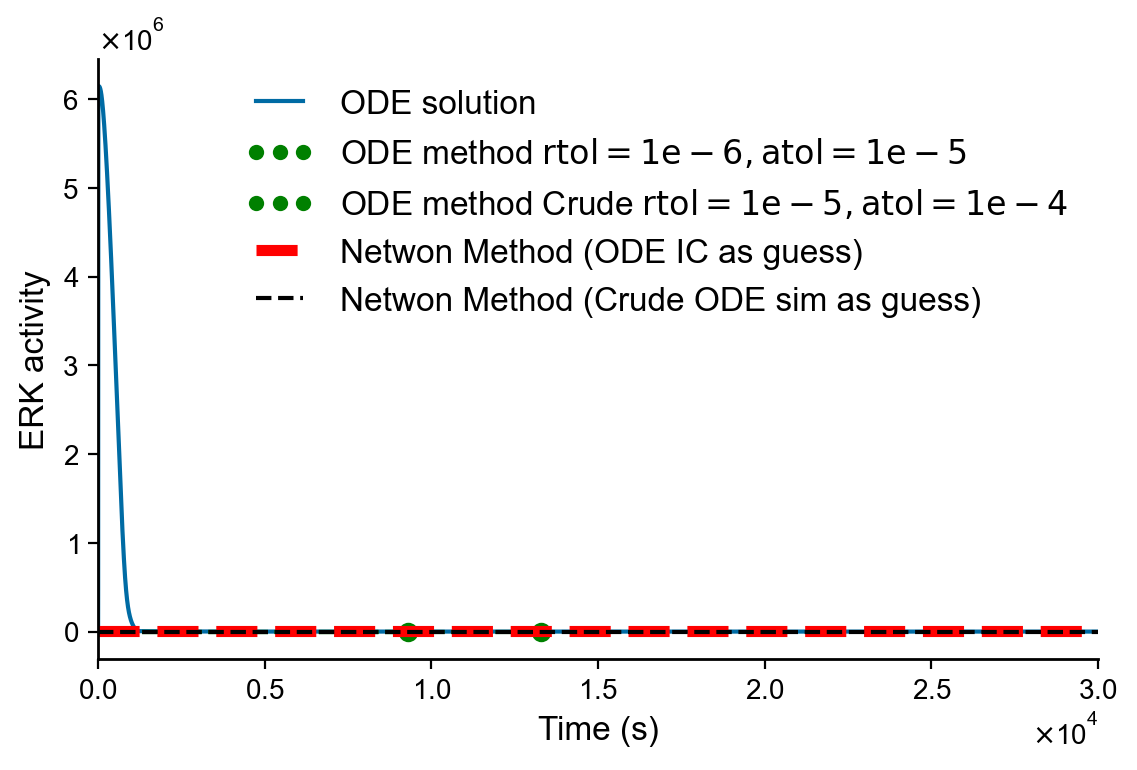

In [304]:
idx = H_2005_ERK_indices[0]-1
# idx2 = H_2005_ERK_indices[0]-1
# idx = 60
fig, ax = get_sized_fig_ax(5,3)
# ax.plot(times, traj[:,H_2005_ERK_indices[0]]+traj[:,H_2005_ERK_indices[1]], label='ODE solution')

ax.plot(times, traj[:,idx+1], label='ODE solution')


# # plot different steady-state solutions
ax.plot(ts_default, sol_default[:,idx+1], 'o', label=r'ODE method $rtol=1e-6, atol=1e-5$', color='g')
ax.plot([0,float(ts_default[0])], [float(sol_default[:,idx+1]), float(sol_default[:,idx+1])], '--', label='', color='g')

ax.plot(ts_crude, sol_crude[:,idx+1], 'o', label=r'ODE method Crude $rtol=1e-5, atol=1e-4$', color='g')
ax.plot([0,float(ts_crude[0])], [float(sol_crude[:,idx+1]), float(sol_crude[:,idx+1])], '--', label='', color='g')

# ax.plot(ts_small, sol_small[:,idx+1], 'o', label=r'ODE method $rtol=1e-10, atol=1e-10$', color='b')
# ax.plot([0,float(ts_small[0])], [float(sol_small[:,idx+1]), float(sol_small[:,idx+1])], '--', label=r'ODE method $rtol=1e-10, atol=1e-10$', color='b')

xlim = ax.get_xlim()
ax.set_xlim([-5, xlim[1]])
xlim = ax.get_xlim()

ax.plot([0,xlim[1]], [float(sol_ODEic.value[idx]), float(sol_ODEic.value[idx])], '--', label=r'Netwon Method (ODE IC as guess)', color='r', linewidth=4)

ax.plot([0,xlim[1]], [float(sol_betterGuess.value[idx]), float(sol_betterGuess.value[idx])], '--', label='Netwon Method (Crude ODE sim as guess)', color='black')

ax.set_xlabel('Time (s)')
ax.set_ylabel('ERK activity')

ax.set_xlim([0, 3e4])
# ax.set_ylim([0, 1e6])

ax.legend()

#### Now a timing test

In [24]:
# start = time.time()
iters = 1
times_NEWTON_H05 = []
times_ODE_H05 = []
RHS_norms_ODE_H05 = []
RHS_norms_Netwon_H05 = []

solver = optx.Newton(atol=1e-10, rtol=1e-10, linear_solver=lx.AutoLinearSolver(well_posed=False), norm=optx.max_norm)
# solver = optx.BFGS(atol=1e-8, rtol=1e-8)
for EGF_idx in range(nEGFS):
    for i in range(25):
        EGF = H_2005_y0_EGF_ins[EGF_idx][H_2005_EGF_idx]
        y0 = H_2005_y0_EGF_ins[EGF_idx]
        param = H_2005_param_samples[i]

        # time Netwon approach
        start = timeit.default_timer()
        sol = find_SS_ODE_init_NEWTON(EGF, param, y0, H_2005,H_2005_RHS, solver, H_2005_EGF_idx, warn=False, max_steps=10, max_init_sim_time=H_2005_t1)
        stop = timeit.default_timer()

        times_NEWTON_H05.append(stop-start)
        RHS_norms_Netwon_H05.append(optx.two_norm(H_2005_RHS(sol, (EGF, param))))
        
        # # time ODE approach with very low tolerances
        # start = timeit.default_timer()
        # sol_ode, _ = find_ss_ODE_solver(H_2005, y0, param, H_2005_t1, event_rtol=1e-6, event_atol=1e-5)
        # stop = timeit.default_timer()
        # times_ODE_H05.append(stop-start)
        # RHS_norms_ODE_H05.append(optx.two_norm(H_2005_RHS(np.squeeze(sol_ode)[H_2005_EGF_idx+1:], (EGF, param))))

In [26]:
RHS = []
for EGF_idx in range(nEGFS):
    for i in range(50):
        RHS.append(optx.two_norm(H_2005_RHS(H_2005_y0_EGF_ins[EGF_idx][1:], (H_2005_y0_EGF_ins[EGF_idx][0], H_2005_param_samples[i]))))
RHS_ic_vH05 = np.mean(RHS)

In [27]:
print('Stats for Hornberg 2005 model: \n')

print(f'Average runtime for Newton method with ODE init: {1000*np.mean(times_NEWTON_H05)} plus/minus {1000*np.std(times_NEWTON_H05)} ms')
# print(f'Average runtime for ODE method: {1000*np.mean(times_ODE_H05)} plus/minus {1000*np.std(times_ODE_H05)} ms')
print(f'Average RHS norm for Newton method with ODE init: {100*np.nanmean(RHS_norms_Netwon_H05)/RHS_ic_vH05}%')
# print(f'Average RHS norm for ODE method: {np.nanmean(RHS_norms_ODE)} plus/minus {np.nanstd(RHS_norms_ODE)}')

Stats for Hornberg 2005 model: 

Average runtime for Newton method with ODE init: 409.5235414917115 plus/minus 498.92778046320063 ms
Average RHS norm for Newton method with ODE init: 0.00016819351561329915%


### VK' 2009

#### Compare the methods

In [47]:
# test root finder with Newton's method for the Shin model from the ODE ic...
nEGFS = 10
EGF_idx = 5
param_idx = 0
EGF = vK_2009_y0_EGF_ins[EGF_idx][2]
y0 = vK_2009_y0_EGF_ins[EGF_idx][2:]
param = vK_2009_param_samples[param_idx]

# solver = optx.BFGS(atol=1e-8, rtol=1e-8)
solver = optx.Newton(atol=1e-6, rtol=1e-6, linear_solver=lx.AutoLinearSolver(well_posed=False), norm=optx.max_norm)


# get y0 as shortish run of ODE
sol, ts = find_ss_ODE_solver(vK_2009, vK_2009_y0_EGF_ins[EGF_idx], param, jnp.inf, vK_2009_ERK_indices, event_rtol=1e-5, event_atol=1e-5)
y0 = jnp.squeeze(sol)[2:]

try:
    print('Trying with ODE sol as Newton initial guess...\n')
    sol_betterGuess = optx.root_find(vK_2009_RHS, solver, y0, args=(EGF,param), max_steps=100000000, options={'lower':jnp.zeros_like(y0)})
    print('The solver converged to the following solution:')
    print(sol_betterGuess.value)
    # print(sol_betterGuess.)
except Exception as e:
    print('THE SOLVER RETURNED THE FOLLOWING ERROR:')
    sol_betterGuess = optx.root_find(vK_2009_RHS, solver, y0, args=(EGF,param), max_steps=100000000, throw=False, options={'lower':jnp.zeros_like(y0)})
    print(e)

Trying with ODE sol as Newton initial guess...

The solver converged to the following solution:
[1.24172228e-21 3.69152416e-25 9.15385701e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.25842141e-01 0.00000000e+00
 1.81089344e-01 8.00438037e-01 2.12593155e-23 6.51703710e-01
 7.00186935e-01 1.33705783e-01 8.94511732e-01 1.10607500e+00
 1.85866420e-02 3.99807050e-01 1.78008952e-01 4.61630669e-01
 8.20392493e-01 3.11527330e-01 7.15252966e-01 5.73074883e-03
 4.37039009e-01 3.32174276e-01 2.30972170e-01 3.11661394e-01
 3.54088334e-01 1.54750415e-02 0.00000000e+00 1.43309182e-26
 0.00000000e+00 0.00000000e+00 9.05934777e-01]


In [30]:
# get SS with differnt ode solve event tolerances
sol_crude, ts_crude = find_ss_ODE_solver(vK_2009, vK_2009_y0_EGF_ins[EGF_idx], param, S_2014_t1, vK_2009_ERK_indices, event_rtol=1e-5, event_atol=1e-3)
sol_default, ts_default = find_ss_ODE_solver(vK_2009, vK_2009_y0_EGF_ins[EGF_idx], param, S_2014_t1, vK_2009_ERK_indices, event_rtol=1e-6, event_atol=1e-5)

# # traj, times = solve_traj(diffrax.ODETerm(vK_2009), vK_2009_y0_EGF_ins[EGF_idx], param, 1e10, np.linspace(0, 1e10, 60000))
traj, times = solve_traj(diffrax.ODETerm(vK_2009), vK_2009_y0_EGF_ins[EGF_idx], param, 1e10, np.linspace(0, 3e5, 900000))

2


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_72714/3158682097.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  ax.plot([0,float(ts_default[0])], [float(sol_default[:,idx+2]), float(sol_default[:,idx+2])], '--', label='', color='g')
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_72714/3158682097.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  ax.plot([0,float(ts_crude[0])], [float(sol_crude[:,idx+2]), float(sol_crude[:,idx+2])], '--', label='', color='k')


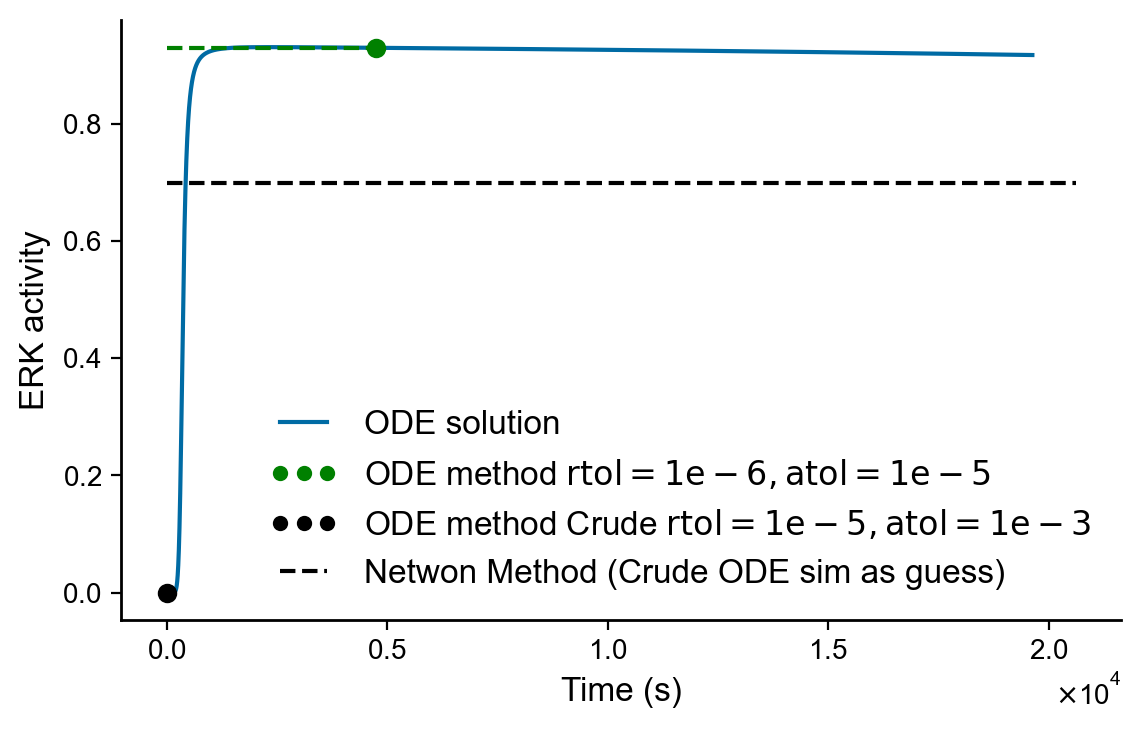

In [55]:
# idx = vK_2009_ERK_indices[1]-1
idx= 12
# idx2 = vK_2009_ERK_indices[0]-1
# idx = 60
fig, ax = get_sized_fig_ax(5,3)
# ax.plot(times, traj[:,vK_2009_ERK_indices[0]]+traj[:,vK_2009_ERK_indices[1]], label='ODE solution')

ax.plot(times, traj[:,idx+2], label='ODE solution')


# # plot different steady-state solutions
ax.plot(ts_default, sol_default[:,idx+2], 'o', label=r'ODE method $rtol=1e-6, atol=1e-5$', color='g')
ax.plot([0,float(ts_default[0])], [float(sol_default[:,idx+2]), float(sol_default[:,idx+2])], '--', label='', color='g')

ax.plot(ts_crude, sol_crude[:,idx+2], 'o', label=r'ODE method Crude $rtol=1e-5, atol=1e-3$', color='k')
ax.plot([0,float(ts_crude[0])], [float(sol_crude[:,idx+2]), float(sol_crude[:,idx+2])], '--', label='', color='k')


# xlim = ax.get_xlim()
# ax.set_xlim([-5, xlim[1]])
xlim = ax.get_xlim()


ax.plot([0,xlim[1]], [float(sol_betterGuess.value[idx]), float(sol_betterGuess.value[idx])], '--', label='Netwon Method (Crude ODE sim as guess)', color='black')

ax.set_xlabel('Time (s)')
ax.set_ylabel('ERK activity')



# ax.set_xlim([0, 1e3])
# ax.set_ylim([0, 1e6])

ax.legend()

#### Timing test

In [34]:
# start = time.time()
iters = 1
times_NEWTON_VK09 = []
times_ODE_VK09 = []
RHS_norms_ODE_VK09 = []
RHS_norms_Netwon_VK09 = []

solver = optx.Newton(atol=1e-10, rtol=1e-10, linear_solver=lx.AutoLinearSolver(well_posed=False), norm=optx.max_norm)
# solver = optx.BFGS(atol=1e-8, rtol=1e-8)
for EGF_idx in range(nEGFS):
    for i in range(50):
        EGF = vK_2009_y0_EGF_ins[EGF_idx][vK_2009_EGF_idx]
        y0 = vK_2009_y0_EGF_ins[EGF_idx]
        param = vK_2009_param_samples[i]

        # time Netwon approach
        start = timeit.default_timer()
        sol = find_SS_ODE_init_NEWTON(EGF, param, y0, vK_2009,vK_2009_RHS, solver, vK_2009_EGF_idx, warn=False, max_steps=100, max_init_sim_time=vK_2009_t1)
        stop = timeit.default_timer()

        times_NEWTON_VK09.append(stop-start)
        RHS_norms_Netwon_VK09.append(optx.two_norm(vK_2009_RHS(sol, (EGF, param))))
        
        # # time ODE approach with very low tolerances
        # start = timeit.default_timer()
        # sol_ode, _ = find_ss_ODE_solver(vK_2009, y0, param, vK_2009_t1, event_rtol=1e-6, event_atol=1e-5)
        # stop = timeit.default_timer()
        # times_ODE_VK09.append(stop-start)
        # RHS_norms_ODE_VK09.append(optx.two_norm(vK_2009_RHS(np.squeeze(sol_ode)[vK_2009_EGF_idx+1:], (EGF, param))))

In [35]:
RHS = []
for EGF_idx in range(nEGFS):
    for i in range(50):
        RHS.append(optx.two_norm(vK_2009_RHS(vK_2009_y0_EGF_ins[EGF_idx][2:], (vK_2009_y0_EGF_ins[EGF_idx][0], vK_2009_param_samples[i]))))
RHS_ic_vK09 = np.mean(RHS)

In [36]:
print('Stats for vonKriegsheim 2009 model: \n')

print(f'Average runtime for Newton method with ODE init: {1000*np.mean(times_NEWTON_VK09)} plus/minus {1000*np.std(times_NEWTON_VK09)} ms')
# print(f'Average runtime for ODE method: {1000*np.mean(times_ODE_VK09)} plus/minus {1000*np.std(times_ODE_VK09)} ms')
print(f'Average RHS percentage of IC RHS norm for Newton method with ODE init: {100*np.nanmean(RHS_norms_Netwon_VK09)/RHS_ic_vK09}%')
# print(f'Average RHS norm for ODE method: {np.nanmean(RHS_norms_ODE_VK09)} plus/minus {np.nanstd(RHS_norms_ODE_VK09)}')

Stats for vonKriegsheim 2009 model: 

Average runtime for Newton method with ODE init: 3.4375313285854645 plus/minus 22.956686227882535 ms
Average RHS percentage of IC RHS norm for Newton method with ODE init: 2.6757283921758345e-13%


### Write a function compute entire dose-response curve using the ODE + Netwon method

First, I want to test if the jax VMAP or the eqx.filter_vmap is faster

In [38]:
@jax.jit
def solve_ss_local(model_dfrx_ode, y0, params, t1,event_rtol,event_atol):
    """ simulates a model over the specified time interval and returns the 
    calculated steady-state values.
    Returns an array of shape (n_species, 1) """
    dt0=1e-3
    solver = diffrax.Kvaerno5()
    event=diffrax.SteadyStateEvent(event_rtol, event_atol)
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0

    sol = diffrax.diffeqsolve(
        model_dfrx_ode, 
        solver, 
        t0, t1, dt0, 
        y0, 
        stepsize_controller=stepsize_controller,
        discrete_terminating_event=event,
        args=params,
        max_steps=600000,
        throw=False,)
    
    return jnp.array(sol.ys)

# vmap steady state solving over different initial conds
#   this means vmapping over the y0 and assuming everything else is fixed
vsolve_ss_local = jax.vmap(solve_ss_local, in_axes=(None, 0, None, None, None, None))

vsolve_ss_local_eqx = eqx.filter_vmap(solve_ss_local, in_axes=(None, 0, None, None, None, None))

In [47]:
print('Timing jax vmap.')
%timeit vsolve_ss_local(diffrax.ODETerm(S_2014), S_2014_y0_EGF_ins, S_2014_param_samples[0], S_2014_t1, 1e-6, 1e-5)

print('Timing eqx filter_vmap.')
%timeit vsolve_ss_local_eqx(diffrax.ODETerm(S_2014), S_2014_y0_EGF_ins, S_2014_param_samples[0], S_2014_t1, 1e-6, 1e-5)


Timing jax vmap.
1.48 ms ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Timing eqx filter_vmap.
1.63 ms ± 27 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Note: Use jax.vmap for this case, it is marginally faster, although the difference is not particularly significant.

Now write a vmapped function to compute the dose-response curve for a given model using the ODE + Netwon method

In [182]:
partial(jax.jit, static_argnames=['y0', 'constant_idxs', 'ODE_RHS'])
def RHS_with_constants(y, p, y0, constant_idxs, ODE_RHS):
    """" This function is used to evaluate the RHS of the ODE when there are some constants.
    
    Args:
        y: the current state vector EXCLUDING the constant species
        args: a tuple containing arguments other than y. The structure should be:
            args = (p, y0, constant_idxs, ODE_RHS)
            where:
                p: the parameter values
                y0: the initial conditions used for ODE sims including ALL states
                constant_idxs: the indices of the species that are constant (ie already,
                    at steady-state so we should exclude them from the Netwon solves)
                ODE_RHS: the function that evaluates the ODE RHS
    """
    y_full = y0.at[jnp.delete(jnp.arange(y0.shape[0]), constant_idxs)].set(y) 
    return ODE_RHS.vf(None, y_full, p)

# @partial(jax.jit, static_argnames=['model', 'solver', 'constant_idxs', 'max_Newton_steps', 'max_init_sim_time', 'event_rtol', 'event_atol'])
def find_SS_ODE_init_NEWTON_internal_vmap(param, y0, model, constant_idxs, 
                    max_Newton_steps=100, max_init_sim_time=jnp.inf, 
                    event_rtol=1e-5, event_atol=1e-4,
                    solver=optx.Newton(atol=1e-10, rtol=1e-10, linear_solver=lx.AutoLinearSolver(well_posed=False), norm=optx.max_norm)):
    """ Finds the steady-state of a model using the ODE steady-state as an initial guess.
    
    This function uses the ODE steady-state as an initial guess for the Newton method.
    
    Args:
        param: the parameter values
        y0: the initial conditions used for ODE sims shape=(n_inputs, n_species)
        model: the model to solve (this is an instance of diffrax.ODETerm)
        solver: the solver to use for root finding
        constant_idxs: the indices of the species that are constant (ie already,
            at steady-state so we should exclude them from the Netwon solves)
        max_Newton_steps: the maximum number of Newton steps to take
        max_init_sim_time: the maximum simulation time to simulate the ODE for during init
        event_rtol: the relative tolerance for the ODE event
        event_atol: the absolute tolerance for the ODE event

    Note: This function assumes that the ODE is autonomous and thus the
        RHS is not time dependent!
        
    Returns:
        The steady-state solution found by the Newton method

    """
    # first run the ode solver to get the initial guess
    sol = vsolve_ss_local(model, y0, param, max_init_sim_time, event_rtol, event_atol)
    y_guess = jax.vmap(jnp.delete, in_axes=(0, None))(jnp.squeeze(sol), constant_idxs)
    print(y_guess)

    RHS = lambda y, args: RHS_with_constants(y, param, y0[0], constant_idxs, model)
    root_find = lambda y: optx.root_find(RHS, solver, y, max_steps=max_Newton_steps, options={'lower':jnp.zeros_like(jnp.squeeze(y_guess[0]))},throw=False)
    
    sol_RF = jax.vmap(root_find)(y_guess)

    return sol_RF.value

# @jax.jit
def find_SS_ODE_init_NEWTON(param, y0, model, constant_idxs, 
                    max_Newton_steps=100, max_init_sim_time=jnp.inf, 
                    event_rtol=1e-5, event_atol=1e-4,
                    solver=optx.Newton(atol=1e-10, rtol=1e-10, linear_solver=lx.AutoLinearSolver(well_posed=False), norm=optx.max_norm)):
    """ Finds the steady-state of a model using the ODE steady-state as an initial guess.
    
    This function uses the ODE steady-state as an initial guess for the Newton method.
    
    Args:
        param: the parameter values
        y0: the initial conditions used for ODE sims shape=(n_species,)
        model: the model to solve (this is an instance of diffrax.ODETerm)
        solver: the solver to use for root finding
        constant_idxs: the indices of the species that are constant (ie already,
            at steady-state so we should exclude them from the Netwon solves)
        max_Newton_steps: the maximum number of Newton steps to take
        max_init_sim_time: the maximum simulation time to simulate the ODE for during init
        event_rtol: the relative tolerance for the ODE event
        event_atol: the absolute tolerance for the ODE event

    Note: This function assumes that the ODE is autonomous and thus the
        RHS is not time dependent!
        
    Returns:
        The steady-state solution found by the Newton method

    """
    # first run the ode solver to get the initial guess
    sol = solve_ss_local(model, y0, param, max_init_sim_time, event_rtol, event_atol)
    y_guess = jnp.delete(jnp.squeeze(sol), constant_idxs)
    print(y_guess)

    RHS = lambda y, args: RHS_with_constants(y, param, y0, constant_idxs, model)
    
    sol_RF = optx.root_find(RHS, solver, y_guess, max_steps=max_Newton_steps, options={'lower':jnp.zeros_like(jnp.squeeze(y_guess))},throw=False)
    
    return sol_RF.value

vfind_SS_ODE_init_NEWTON = jax.vmap(find_SS_ODE_init_NEWTON, in_axes=(None, 0, None, None))

In [183]:
# test the functions
sol_internal_vmap = find_SS_ODE_init_NEWTON_internal_vmap(S_2014_param_samples[0], jnp.array(S_2014_y0_EGF_ins), diffrax.ODETerm(S_2014), jnp.array([0]))

sol_vmap = vfind_SS_ODE_init_NEWTON(S_2014_param_samples[0], jnp.array(S_2014_y0_EGF_ins), diffrax.ODETerm(S_2014), jnp.array([0]))

# compare results
print('The norm of the difference between the two methods is:', optx.two_norm(sol_internal_vmap-sol_vmap))

[[9.02618246e-12 8.29792681e-09 2.15900614e-10 6.54740242e-12
  4.03432030e-14 1.34016619e-18]
 [1.51531913e-11 1.39305893e-08 3.62454748e-10 1.09918041e-11
  6.77283297e-14 2.24987686e-18]
 [2.54392383e-11 2.33867191e-08 6.08490292e-10 1.84530808e-11
  1.13702587e-13 3.77710367e-18]
 [4.27074951e-11 3.92616893e-08 1.02153539e-09 3.09790948e-11
  1.90884348e-13 6.34102063e-18]
 [7.16975131e-11 6.59126011e-08 1.71495617e-09 5.20077968e-11
  3.20457373e-13 1.06453417e-17]
 [1.20366070e-10 1.10654112e-07 2.87907091e-09 8.73108079e-11
  5.37985023e-13 1.78714727e-17]
 [2.02071032e-10 1.85765928e-07 4.83338343e-09 1.46577480e-10
  9.03171129e-13 3.00027857e-17]
 [3.62887908e-10 5.13957969e-05 6.54019391e-05 1.34569934e-03
  3.34121070e-02 1.62794125e-02]
 [6.09217602e-10 7.64949060e-05 9.73314912e-05 1.99982124e-03
  4.00938510e-02 1.70858257e-02]
 [1.02275675e-09 1.17357202e-04 1.49281353e-04 3.05607393e-03
  4.66462625e-02 1.77080899e-02]]
Traced<ShapedArray(float64[6], weak_type=True)>wi

In [ ]:
np.array()